
# Overfitting, the Bias-Variance tradeoff, Regularization, and Double Descent

We have seen a number of supervised learning algorithms, which learn deterministic mappings from input to output. In this chapter, we will analyze overfitting and underfitting in supervised learning, in order to understand the general conditions under which we can expect a supervised learning algorithm to perform well.

Preamble: Run the cells below to import the necessary Python packages

Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/overfitting_bias_variance_free_lunch.ipynb)

<!-- These notes are modified and extended from [notes](https://github.com/kuleshov/cornell-cs5785-2022-applied-ml/blob/main/slides/lecture5-regularization.ipynb) by **Volodymyr Kuleshov** at Cornell Tech. These have been modified from the originals to segue into a the physics course, and to motivate double-descent -->

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Polynomial Regression

Recall that, in supervised learning, we fit a linear model to a dataset $X \in \mathbb{R}^{N_\text{data} \times N_\text{features}}$ and a vector of labels $y \in \mathbb{R}^{N_\text{data}}$. Here, we will consider the simple one-dimensional case $X \in \mathbb{R}^{N_\text{data} \times 1}$ and $y \in \mathbb{R}^{N_\text{data}}$

Text(0, 0.5, 'y')

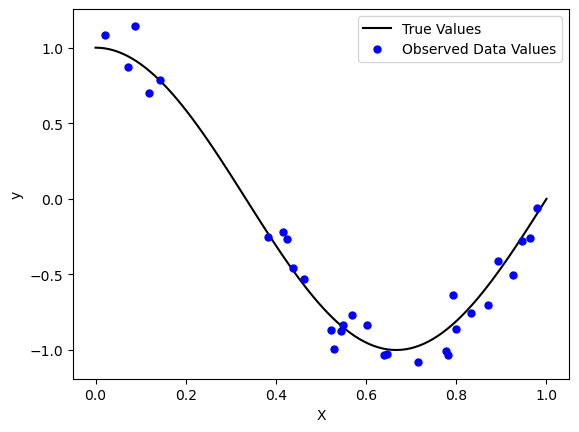

In [ ]:
true_fn = lambda X: np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X_train = np.sort(np.random.rand(n_samples))
y_train = true_fn(X_train) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
y_test = true_fn(X_test)


plt.plot(X_test, true_fn(X_test), 'k', label="True Values")
plt.plot(X_train, y_train, '.b', markersize=10, label="Observed Data Values")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")


One option to find the relationship between the features and the labels is to fit a linear model of the form

$$
\mathbf{y} = \boldsymbol{\theta}^\top \mathbf{X}
$$

where $\boldsymbol{\theta} \in \mathbb{R}^{1}$ is a *scalar*, because each data point has only one feature, and we want to map it to one regression target value.

### Bias as a feature in linear regression

You might recall that univariate linear regression models can be written as

$$
\mathbf{y} = \theta \mathbf{X} + b
$$

where $\mathbf{X}, \mathbf{y} \in \mathbb{R}^{N_\text{data}}$ and all model weights are scalars. We can "lift" the dimensionality of the feature space by adding a constant feature to the data, so that the model becomes

$$
\mathbf{y} = \boldsymbol{\theta}^\top \mathbf{X}
$$

where $\boldsymbol{\theta} \in \mathbb{R}^{2}$ and $\mathbf{X} \in \mathbb{R}^{N_\text{data} \times 2}$, with the first column of $\mathbf{X}$ being all ones.

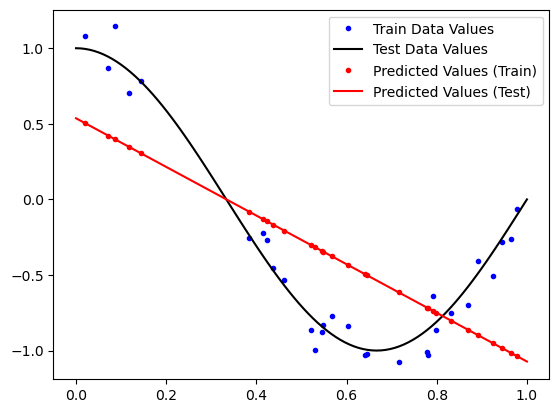

In [141]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train[:, None], y_train)

# Predict the values on train and test
y_pred_train = model.predict(X_train[:, None])
y_pred_test = model.predict(X_test[:, None])

plt.plot(X_train, y_train, '.b', label="Train Data Values")
plt.plot(X_test, y_test, 'k', label="Test Data Values")
plt.plot(X_train, y_pred_train, '.r', label="Predicted Values (Train)")
plt.plot(X_test, y_pred_test, 'r', label="Predicted Values (Test)")

plt.legend(loc="best")

### Nonlinear features are more expressive

What if we wanted to fit a polynomial instead? We could instead solve a polynomial regression problem of the form

$$
\mathbf{y} = \boldsymbol{\theta}^\top \Phi(\mathbf{X})
$$

where $\Phi(\mathbf{X})$ is a matrix of features that are polynomial transformations of the original features,
$$
\Phi(\mathbf{X}) = \begin{bmatrix}
1 & x_{11} & x_{12} & \dots & x_{1d} & x_{11}^2 & x_{12}^2 & \dots & x_{1d}^2 & \dots \\
1 & x_{21} & x_{22} & \dots & x_{2d} & x_{21}^2 & x_{22}^2 & \dots & x_{2d}^2 & \dots \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots \\
1 & x_{n1} & x_{n2} & \dots & x_{nd} & x_{n1}^2 & x_{n2}^2 & \dots & x_{nd}^2 & \dots \\
\end{bmatrix}
$$

Thus, in this lifted feature space the labels remain the same $\mathbf{y} \in \mathbb{R}^{N_\text{data}}$, but the transformed features $\Phi(\mathbf{X}) \in \mathbb{R}^{N_\text{data} \times N_\text{features}}$ where $N_\text{features} > 1$. As a result, the model weights $\boldsymbol{\theta} \in \mathbb{R}^{N_\text{features}}$.

Geature-wise transformations are sometimes called *basis functions* or *kernels*. For a single datapoint, the resulting regression problem has the form

$$ f_\theta(x) := \theta^\top \phi(x) = \sum_{j=0}^p \theta_j x^j $$
that is linear in $\theta$ but non-linear in $x$ because the features 
$$\phi(x) = [1\; x\; \ldots\; x^p]$$ 
are non-linear. Using these features, we can fit any polynomial of degree $p$ by first transforming the features and then fitting a linear model using standard methods

# Polynomial Regression

Instead of directly performing nonlinear transformations of the input features, we can use the `PolynomialFeatures` class from `sklearn.preprocessing` to compute the lifted feature matrix for us. Because it's built into `scikit-learn`, it automatically has the right API to be used within a standard machine learning model. After transforming the input data, we will pass the transformed data to scikit-learn's `LinearRegression` or `Ridge` classes to fit a linear model to the transformed data

`scitkit-learn` allows us to combine these operations into a single combined model with the `Pipeline` class. We will score the quality of the model using the $R^2$ score on both the training and test data

Train R2 Score (Degree 1): 0.473679628749485
Test R2 Score (Degree 1): 0.5796351746300188
Train R2 Score (Degree 2): 0.93080078598832
Test R2 Score (Degree 2): 0.9189645762039556
Train R2 Score (Degree 3): 0.9709160115202458
Test R2 Score (Degree 3): 0.9911295021744566


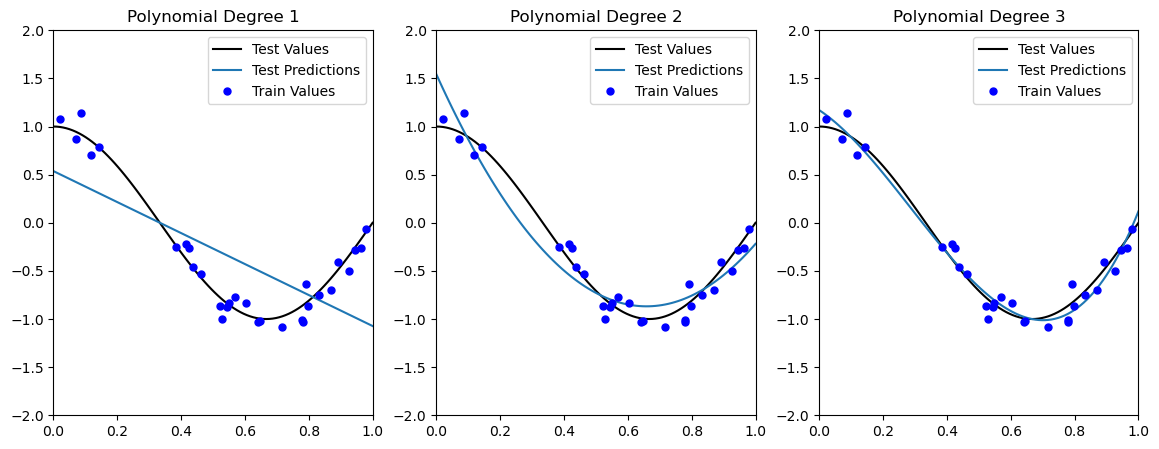

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degrees = [1, 2, 3]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)

    ax.plot(X_test, y_test, color='k', label="Test Values")    
    ax.plot(X_test, pipeline.predict(X_test[:, None]), label="Test Predictions")
    ax.plot(X_train, y_train, '.b', markersize=10, label="Train Values")
    print(f"Train R2 Score (Degree {degrees[i]}): {pipeline.score(X_train[:, None], y_train)}")
    print(f"Test R2 Score (Degree {degrees[i]}): {pipeline.score(X_test[:, None], y_test)}")

    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title(f"Polynomial Degree {degrees[i]}")

# Why not always lift the features? Diminishing returns of the Vandermonde matrix

The Vandermonde matrix $\Phi \in \mathbb{R}^{N \times p}$ is a matrix whose rows are the features $\phi(x)$ for a set of points $x_1,\ldots,x_n$. For example, if we have $n=3$ points $x_1=1$, $x_2=2$, $x_3=3$, and $p=2$, then the Vandermonde matrix is
$$
\begin{bmatrix}
1 & 1 & 1 \\
1 & 2 & 4 \\
1 & 3 & 9
\end{bmatrix}
$$

Below, we plot the Vandermonde matrix for $N_\text{data}=3$ points and $p=0,2,4,9$

In [144]:
xx = np.array([1, 2, 3])

print(np.vander(xx, 2, increasing=True), end='\n\n')

print(np.vander(xx, 3, increasing=True), end='\n\n')

print(np.vander(xx, 5, increasing=True), end='\n\n')

print(np.vander(xx, 10, increasing=True), end='\n\n')

[[1 1]
 [1 2]
 [1 3]]

[[1 1 1]
 [1 2 4]
 [1 3 9]]

[[ 1  1  1  1  1]
 [ 1  2  4  8 16]
 [ 1  3  9 27 81]]

[[    1     1     1     1     1     1     1     1     1     1]
 [    1     2     4     8    16    32    64   128   256   512]
 [    1     3     9    27    81   243   729  2187  6561 19683]]





### Solving yet another least-squares problem

In principle, we can simply fit a polynomial of degree $p$ to a set of points $(x_1,y_1),\ldots,(x_n,y_n)$ by solving the linear system $\Phi\theta = y$. 

$$
\begin{bmatrix}
1 & x_1 & x_1^2 & \ldots & x_1^p \\
1 & x_2 & x_2^2 & \ldots & x_2^p \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \ldots & x_n^p
\end{bmatrix}

\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_p
\end{bmatrix}

=

\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
$$

Notice how we "linearized" our problem by applying nonlinear functions to our features. This is the basis of many "kernel methods" in machine learning.

### Properties of the Vandermonde matrix

+ The Vandermonde matrix $\Phi$ is a square matrix of size $n\times p$, where $n$ is the number of datapoints and $p$ is one plus the degree of the polynomial that we want to fit. In this sense, the "features" of the model are just higher powers of existing features, making the features redundant.

+ If $p = n$, then the Vandermonde matrix is square and invertible, and the linear system has a unique solution via $\Phi^{-1}$. Notice how the Vandermond matrix always has full rank in this case, if the points $x_1,\ldots,x_n$ are all distinct. However, the matrix becomes singular if any of the datapoints are repeated.

+ However, if $p > n$, then the Vandermonde matrix is rectangular and the linear system is not guaranteed to have a unique solution. Conversely, if $p < n$, then the Vandermonde matrix is rank-deficient and the linear system is not guaranteed to have a solution. In this case, we can find the least-squares solution using the Moore-Penrose pseudoinverse $(\Phi^\top\Phi)^{-1}\Phi^\top$.

+ **Important**, as the number of points increases, the Vandermonde matrix becomes ill-conditioned, which degrades the accuracy of the solution.


Text(0, 0.5, 'Condition number')

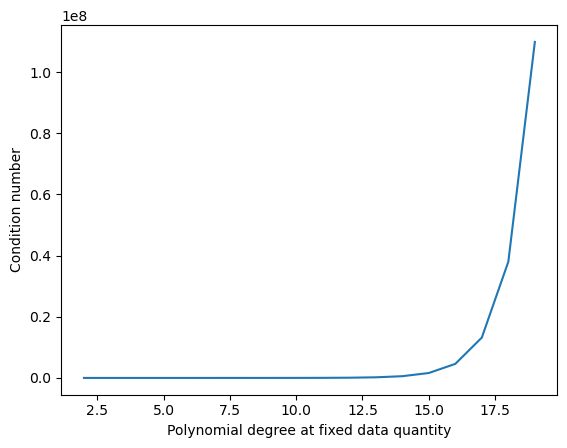

In [145]:
xx = np.array([1, 2, 3]) # 3 data points

pvals = range(2, 20)
all_condition_numbers = []
for i in pvals:
    all_condition_numbers.append(np.linalg.cond(np.vander(xx, i, increasing=True)))

plt.plot(pvals, all_condition_numbers)
plt.xlabel('Polynomial degree at fixed data quantity')
plt.ylabel('Condition number')

## How can we interpret this effect?

Let's try defining a data matrix with $N_\text{data}=2$. What do the column vectors of a high-degree Vandermonde matrix look like?

In [146]:
xx = np.array([1.0, 2.0]) # 2 data points

phi = np.vander(xx, 10, increasing=True)

phi /= np.linalg.norm(phi, axis=0, keepdims=True)


Text(0.5, 1.0, 'All columns')

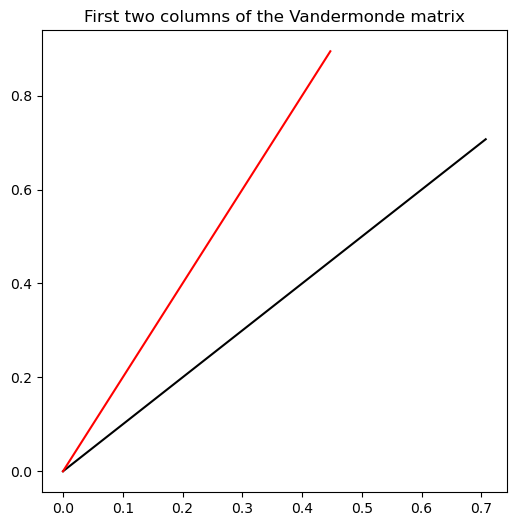

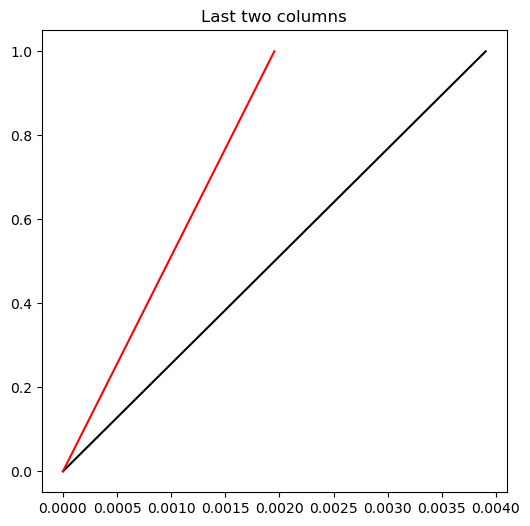

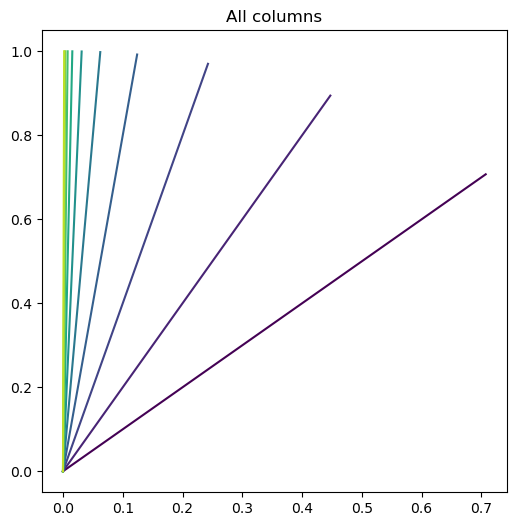

In [147]:
def plot_vector(vec, **kwargs):
    plt.plot([0, vec[0]], [0, vec[1]], **kwargs)

plt.figure(figsize=(6, 6))
plot_vector(phi[:, 0], color='k', label='First column')
plot_vector(phi[:, 1], color='r', label='Second column')
plt.title("First two columns of the Vandermonde matrix")


plt.figure(figsize=(6, 6))
plot_vector(phi[:, -2], color='k', label='First column')
plot_vector(phi[:, -1], color='r', label='Second column')
plt.title('Last two columns')

# plot with color gradient
plt.figure(figsize=(6, 6))
for i in range(10):
    plot_vector(phi[:, i], color=plt.cm.viridis(i / 10))
plt.title('All columns')


Text(0, 0.5, 'Datapoint index')

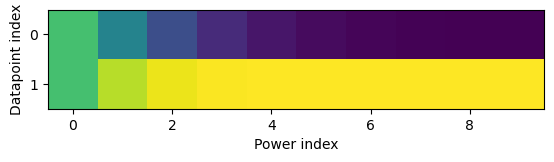

In [38]:
plt.imshow(phi)
plt.xlabel('Power index')
plt.ylabel('Datapoint index')

The largest element of our data vector $x$ begins to dominate at higher powers of $x$, causing the column vectors to become more and more similar to each other, and resulting in the least-squares problem becoming ill-conditioned.

**Nothing comes for free!** If we don't have sufficient features or measurement channels, we can't always just make up new ones as functions of our existing features. Eventually, redundancy catches up with us. We can't convert an underdetermined problem to an overdetermined problem by adding redundant features.


### Residual Scatter: Determining model complexity *without* looking at the test dataset

+ Although fitting a linear model does not work well, quadratic or cubic polynomials seem to improve the fit to both the training and test data. Increasing the model expressivity therefore seems to improve the model's ability to fit the training data, *and* generalize to unseen test data.

+ We can also assess whether a given model is underfitting by plotting the residuals, which are the differences between the predicted values and the true values. If the residuals are not random, then the model is underfitting.

    If the true values are $y$ and the predicted values are $\hat{y}$, then the residuals are $y - \hat{y}$. The reason we expect uniform scatter is that our linear regression model can be seen as defining a data-generating process of the form

    $$
    y = \theta^\top \phi(x) + \epsilon
    $$

    where $\epsilon$ is a random variable with zero mean and constant variance. The residuals are therefore given by

    $$
    y - \theta^\top \phi(x) = \epsilon
    $$

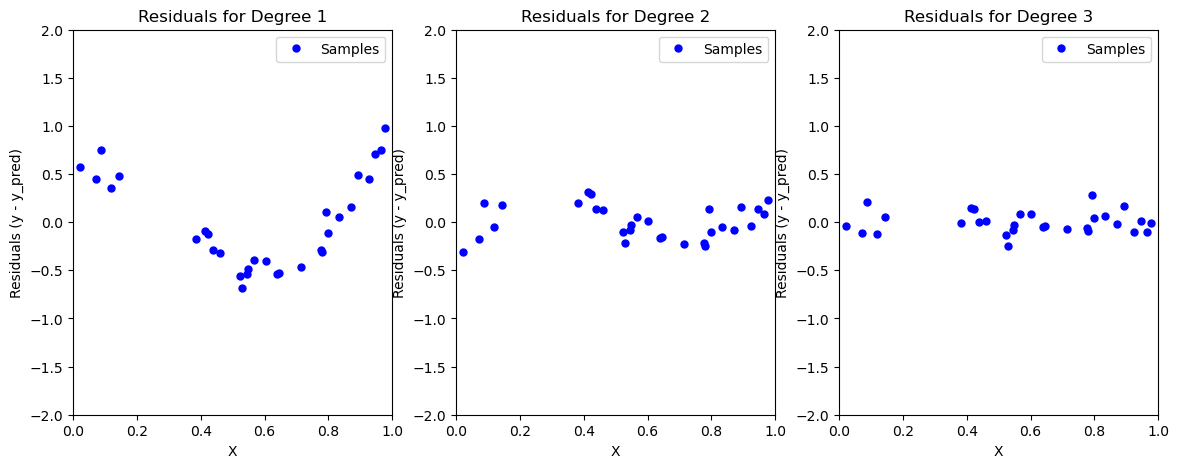

In [148]:
## Plot residuals for each model
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)

    ax.plot(X_train, y_train - pipeline.predict(X_train[:, None]), '.b', markersize=10, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Residuals for Degree {}".format(degrees[i]))
    plt.xlabel("X")
    plt.ylabel("Residuals (y - y_pred)")

    # plt.fi

We can see one heuristic for determining whether we have chosen a sufficiently-expressive model: **Uniform scatter in the residuals**

Hypothetically, we want to view our data generating process as comprising a deterministic function $f$ and a random noise term $\epsilon$. We want to fit a model that is close to $f$ and that is able to capture everything except the variability in $\epsilon$.

$$
y_i = f(x_i) + \epsilon_i
$$

where $f(x_i) = \theta_0 + \theta_1 x_i + ...$ and $\epsilon_i$ is a random variable with mean 0 and variance $\sigma^2$. When we compute our residuals, we are computing the difference between the true values $y_i$ and our model's predictions $\hat{y}_i = f(x_i)$.
$$
r_i = y_i - f(x_i)
$$

Thus we want to $r_i$ to look like a zero-centered random distribution, consistent with our implicit model of the generating process for this dataset.

# What happens when our model complexity is too high?

+ Increase the degree of our polynomial improved our fit accuracy by producing a model that explained more of the variance in the data.
+ Our residuals appeared more uniform as well, suggesting that our model stopped underfitting


What happens if we further increase the degree of the polynomial?

Runge's phenomenon: can fit an $N$-point dataset perfectly with a polynomial of degree $N$.

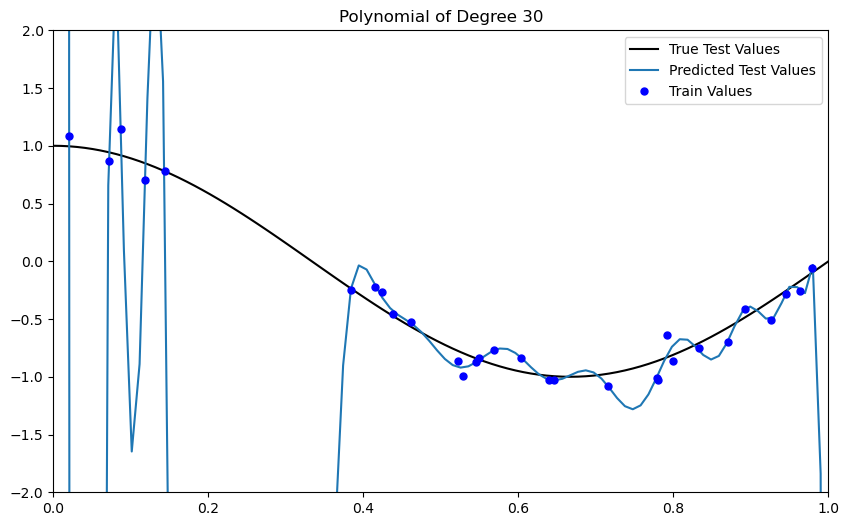

In [149]:
degrees = [30]
plt.figure(figsize=(10, 6))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)

    y_pred_test = pipeline.predict(X_test[:, None])

    ax.plot(X_test, y_test, color='k', label="True Test Values")
    ax.plot(X_test, y_pred_test, label="Predicted Test Values")
    ax.plot(X_train, y_train, '.b', markersize=10, label="Train Values")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

#### Let's quantify this effect

In [150]:
print(f"Train R2 Score (Degree {degrees[i]}): {pipeline.score(X_train[:, None], y_train)}")
print(f"Test R2 Score (Degree {degrees[i]}): {pipeline.score(X_test[:, None], y_test)}")

Train R2 Score (Degree 30): 0.9950194388972539
Test R2 Score (Degree 30): -86515.89762356045


### Model complexity

+ This is a nebulous concept in machine learning. In principle, it's a function of the number of trainable parameters in a model

+ However, we've seen before that regularizers and constraints can reduce the effective number of degrees of freedom, and that not all parameter combinations are "reachable" during training.

+ Nonetheless, we'll treat the number of parameters as an upper bound on the complexity of a model.

+ Other measures of complexity include the VC dimension, the Rademacher complexity, and the margin of a classifier.


#### Plotting train/test error vs. model complexity

+ Usually, model complexity is controlled by a hyperparameter, such as the degree of a polynomial, the number of layers in a neural network, the number of trees in a random forest, or the strength of a regularizer.

+ We can see how the training versus validation error changes as we vary the hyperparameter, to see how overfitting emerges.

+ By convention, we normally plot *error* instead of *accuracy*, so that the error is always decreasing as the model improves. In this case, we will record $1 - R^2$ as our error metric.

Text(0, 0.5, 'Mean Squared Error')

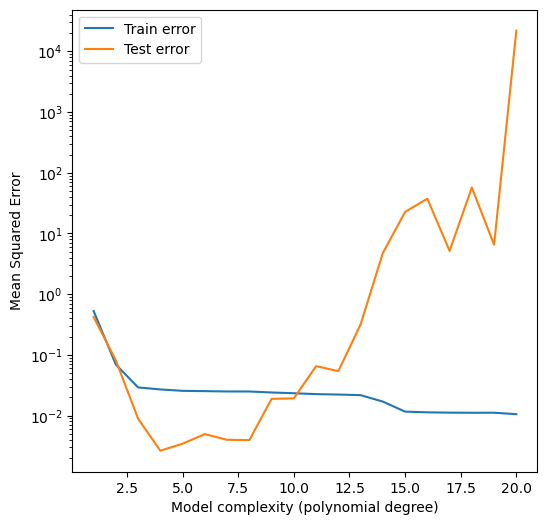

In [152]:
## Plot train and test error versus model size
from sklearn.metrics import r2_score

degrees = range(1, 21)
train_errors = []
test_errors = []
for degree in degrees:
    polynomial_features = PolynomialFeatures(degree=degree,)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)

    y_pred_train = pipeline.predict(X_train[:, None])
    y_pred_test = pipeline.predict(X_test[:, None])

    train_errors.append(1 - r2_score(y_train, y_pred_train))
    test_errors.append(1 - r2_score(y_test, y_pred_test))

plt.figure(figsize=(6, 6))
plt.semilogy(degrees, train_errors, label='Train error')
plt.semilogy(degrees, test_errors, label='Test error')
plt.legend(loc='best')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('Mean Squared Error')

Looking at this graph, we can see several patterns

+ The training error decreases as the model complexity increases. This is because the model is able to fit the training data more closely as it becomes more complex.

+ The test error initially decreases as the model complexity increases, as the model reaches a model class that is able to fit the data more closely.

+ The test error then increases as the model complexity increases further. This is because the model is overfitting to the training data, and is not able to generalize to the test data.

### We'd say that the best model is the one that minimizes the test error.

# The Bias-Variance Tradeoff

We will return to our convention that each dataset comes from an underlying generator, which is unknown. We can think of the data as being generated by a function $f(x)$, plus some random noise $\epsilon$.

$$
    y_i = f(x_i) + \epsilon_i
$$

Suppose we fit a model $\hat{f}_\theta(x)$ to the data, where $\theta$ are the parameters of the model. We can write the overall mea squared error of the model as

$$
    \text{MSE} = \mathbb{E}_i[(y_i - \hat{f}_\theta(x_i))^2]
$$
where we are taking the expectation over the data points (indexed by $i$) in the dataset.

We can expand this term by adding and subtracting the unknown true generating function $f(x)$,
$$
    y_i - \hat{f}_\theta(x_i) = y_i - f(x_i) + f(x_i) - \hat{f}_\theta(x_i)
$$
to get
$$
    \text{MSE} = \mathbb{E}_i[(y_i - f(x_i))^2] + \mathbb{E}_i[(f(x_i) - \hat{f}_\theta(x_i))^2] + 2\mathbb{E}_i[(y_i - f(x_i))(f(x_i) - \hat{f}_\theta(x_i))]
$$
Simplifying,
$$
    \text{MSE} = \epsilon^2 + \mathbb{E}_i[(f(x_i) - \hat{f}_\theta(x_i))^2] + 2\mathbb{E}_i[(y_i - f(x_i))(f(x_i) - \hat{f}_\theta(x_i))]
$$
The last term is the cross-term between the noise and the model error. We can simplify this term by noting that the noise is independent of the model error, so that the expectation of the product is the product of the expectations. This term is therefore zero, and we have
$$
    \text{MSE} = \epsilon^2 + \mathbb{E}_i[(f(x_i) - \hat{f}_\theta(x_i))^2]
$$

We can now expand the second term in the sum by adding and subtracting the expected value of the model error $\mathbb{E}_i[\hat{f}_\theta(x_i)]$, which we denote as $\bar{f}$,
$$
    f(x_i) - \hat{f}_\theta(x_i) = f(x_i) - \bar{f} + \bar{f} - \hat{f}_\theta(x_i)
$$
Substituting this back into the equation for the MSE, we get
$$
    \text{MSE} = \epsilon^2 + \mathbb{E}_i[(f(x_i) - \bar{f})^2] + \mathbb{E}_i[(\bar{f} - \hat{f}_\theta(x_i))^2] + 2\mathbb{E}_i[(f(x_i) - \bar{f})(\bar{f} - \hat{f}_\theta(x_i))]
$$
The last cross term is again zero, because the model error is independent of the expected model error (there is no covariance between the two). We can simplify our expression to
$$
    \text{MSE} = \epsilon^2 + \mathbb{E}_i[(f(x_i) - \bar{f})^2] + \mathbb{E}_i[(\bar{f} - \hat{f}_\theta(x_i))^2]
$$
The first term is the irreducible error, which is the error that we get no matter how good our model is. The second term is the **bias** of the model, which the error associated with making a naive prediction that all data points are equal to the expected value of the model. This term is minimized if the data has a very simple underlying structure (like a constant). The third term is the **variance** of the model across all datapoints.

[1] [Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning: data mining, inference, and prediction. Springer Science & Business Media.](https://hastie.su.domains/ElemStatLearn/)

[2] [Breiman, L. (2001). Statistical modeling: The two cultures. Statistical Science, 16(3), 199-231.](https://projecteuclid.org/euclid.ss/1009213726)




### Overfitting

+ A very expressive model (e.g., a high degree polynomial) fits the training dataset perfectly.

+ But the model makes highly incorrect predictions outside this dataset, and doesn't generalize.

+ We would say that the overfit model exhibits **high variance** in its score across different hypothetical testing sets

+ We could also say that the model has **low bias** because it will fit any training data very well.


### Underfitting

+ A small model (e.g. a straight line), will not fit the training data well.

+ Therefore, it will also not be accurate on new data.

+ The model will, however, exhibit **low variance** in its error on random testing sets. 

+ We say that it has **high bias** due to its strong tendency to do a limited number of things.


### Determining Overfitting vs. Underfitting

We can diagnose overfitting and underfitting by measuring performance on a the held out *test dataset* (data that was not used for training). 

+ If training perforance is high but test performance is low, we are overfitting.

+ If training and testing performance are both low, we are underfitting.

The gap between train and test scores is therefore one measure of overfitting. Larger gaps indicate more overfitting. How do we choose the correct model complexity? For our polynomial example, $p$ is a hyperparameter. We need to tune it on a validation set, or run cross-validation on our training partition

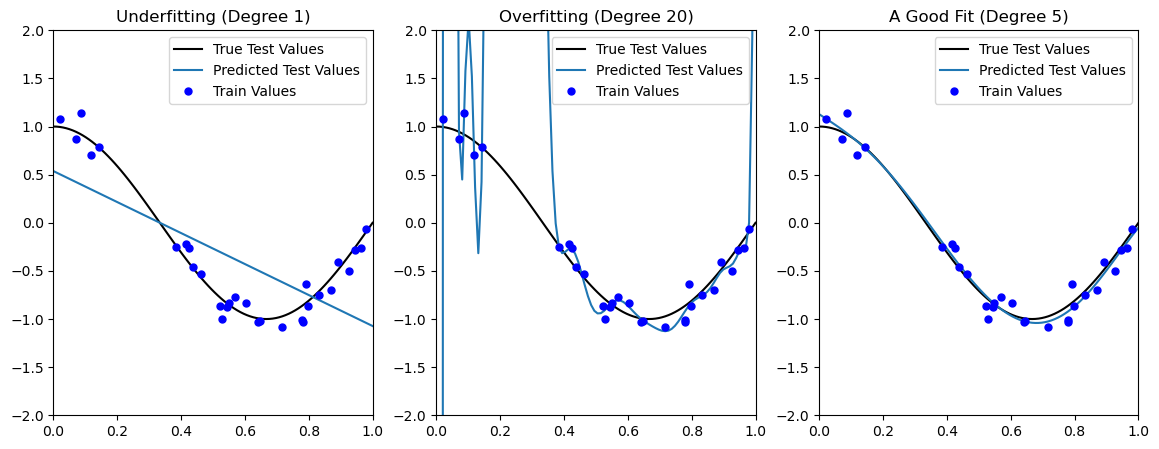

In [154]:
degrees = [1, 20, 5]
titles = ['Underfitting', 'Overfitting', 'A Good Fit']
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)

    y_pred_test = pipeline.predict(X_test[:, None])

    ax.plot(X_test, y_test, color='k', label="True Test Values") 
    ax.plot(X_test, y_pred_test, label="Predicted Test Values")
    ax.plot(X_train, y_train, '.b', markersize=10, label="Train Values")

    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("{} (Degree {})".format(titles[i], degrees[i]))


## How to Fix Underfitting

+ Feature engineering: find better features that will make the dataset easier to fit.

+ Pick a more expressive model class (random forests or neural networks instead of linear models).

+ Pick an optimization algorithm that can find better parameters (SGD instead of gradient descent).

## How to Fix Overfitting

+ Use a simpler model class (a linear model instead of a neural net)

+ Use fewer trainable parameters (a smaller neural net)

+ Keep the same model, but collect more training data

+ **Regularization: modify the training process to penalize overly complex models.**


# Regularization

+ Regularization is a technique to prevent overfitting (or increase bias) by adding a penalty term to the loss function.

+ We will try applying L2 or Ridge regularization to our polynomial regression model.

+ We will also calculate the accuracy on the training set and the test set. We will again use the coefficient of determination $R^2$ as our metric.

+ Why are we using L2 regularization instead of L1 (Lasso)?

### L2 Regularization for Polynomial Regression

Let's consider an application to the polynomial model we have seen so far. Given polynomial features $\phi(x)$, we optimize the following objective:

$$ J(\theta) = \frac{1}{2n} \sum_{i=1}^n \left( y^{(i)} - \theta^\top \phi(x^{(i)}) \right)^2 + \frac{\lambda}{2} \cdot ||\theta||_2^2. $$



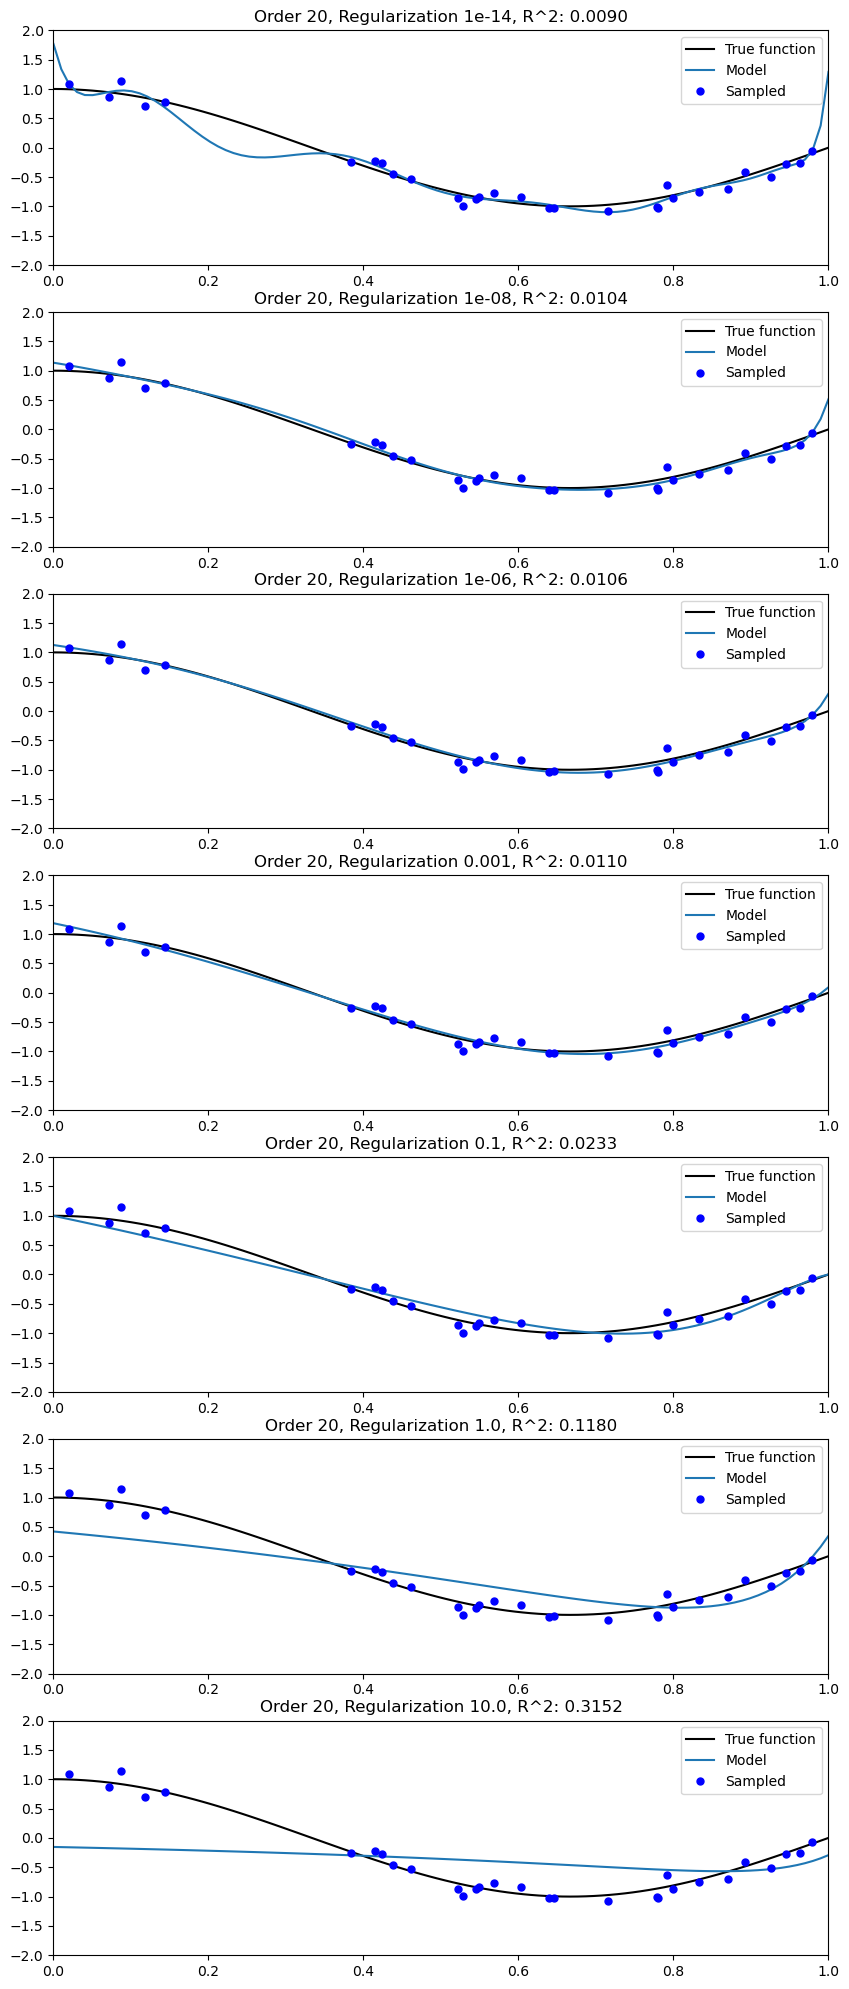

In [156]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

lambda_values = [1e-14, 1e-8, 1e-6, 1e-3, 1e-1, 1e0, 1e1]

all_train_errors = []
all_test_errors = []

plt.figure(figsize=(10, 25))
for i, lambda_value in enumerate(lambda_values):
    ax = plt.subplot(len(lambda_values), 1, i + 1)
    polynomial_features = PolynomialFeatures(degree=20)
    linear_regression = Ridge(alpha=lambda_value)
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)

    y_pred_train = pipeline.predict(X_train[:, None])
    y_pred_test = pipeline.predict(X_test[:, None])

    score_train = 1 - r2_score(y_train, y_pred_train)
    score_train = np.mean((y_train - y_pred_train) ** 2)
    all_train_errors.append(1 - score_train)
    score_test = 1 - r2_score(y_test, y_pred_test)
    score_test = np.mean((y_test - y_pred_test) ** 2)
    all_test_errors.append(1 - score_test)

    ax.plot(X_test, y_test, color='k', label="True function")    
    ax.plot(X_test, y_pred_test, label="Model")
    ax.plot(X_train, y_train, '.b', markersize=10, label="Sampled")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    
    ax.set_title(f"Order {20}, Regularization {lambda_value}, R^2: {(score_train):.4f}")

Text(0, 0.5, 'Mean Squared Error')

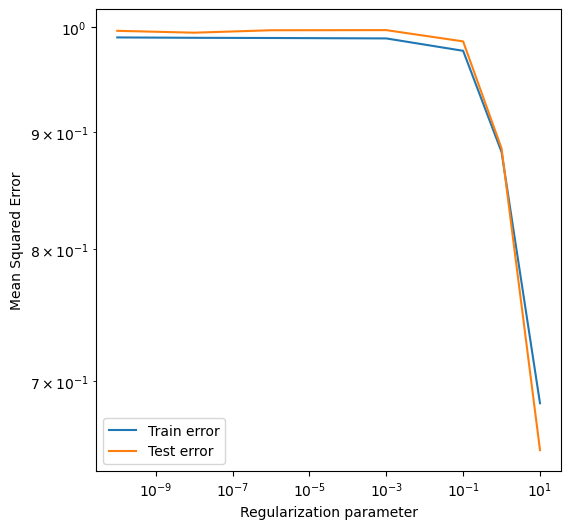

In [92]:
plt.figure(figsize=(6, 6))
plt.loglog(lambda_values, all_train_errors, label='Train error')
plt.loglog(lambda_values, all_test_errors, label='Test error')
plt.legend(loc='best')
plt.xlabel('Regularization parameter')
plt.ylabel('Mean Squared Error')


# Regularization reduces the variance of the model

We implement regularized and polynomial regression of degree 15 on three random training sets sampled from the same distribution.

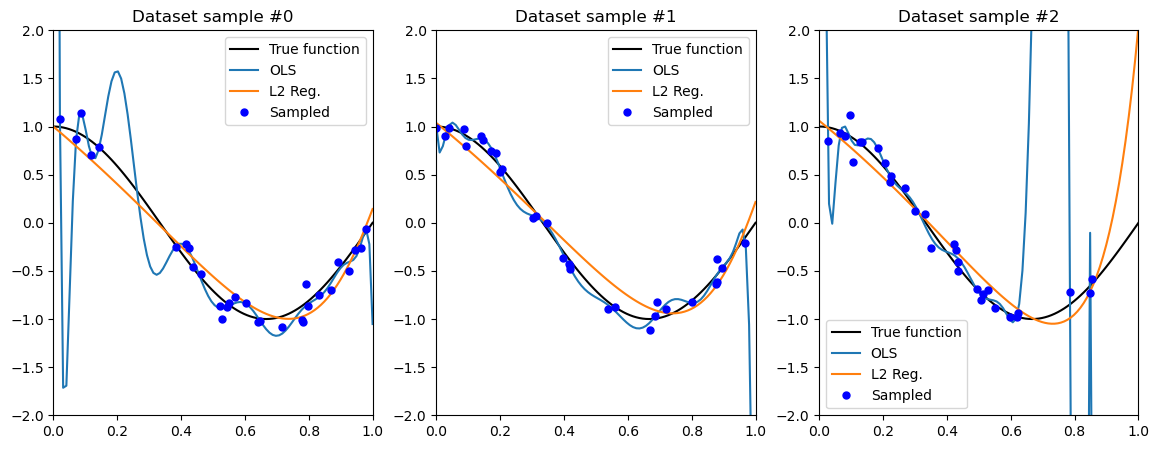

In [108]:
from sklearn.linear_model import Ridge

degrees = [15]*3
plt.figure(figsize=(14, 5))
for idx, i in enumerate(range(len(degrees))):
    # sample a dataset
    np.random.seed(idx)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = true_fn(X) + np.random.randn(n_samples) * 0.1

    # fit a least squares model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    
    # fit a Ridge model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = Ridge(alpha=0.1) # sklearn uses alpha instead of lambda
    pipeline2 = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline2.fit(X[:, np.newaxis], y)    

    # visualize results
    ax = plt.subplot(1, len(degrees), i + 1)
    ax.plot(X_test, true_fn(X_test), color='k', label="True function")
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="OLS")
    ax.plot(X_test, pipeline2.predict(X_test[:, np.newaxis]), label="L2 Reg.")    
    ax.plot(X, y, '.b', markersize=10, label="Sampled")


    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Dataset sample #{}".format(idx))

We can get a better idea of what's going on by printing the learned weights $\theta$ for each model.

Text(0.5, 1.0, 'Ridge Coefficients')

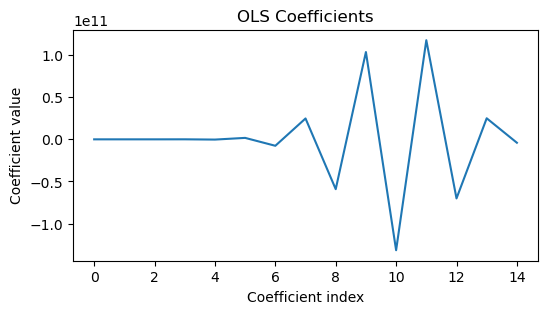

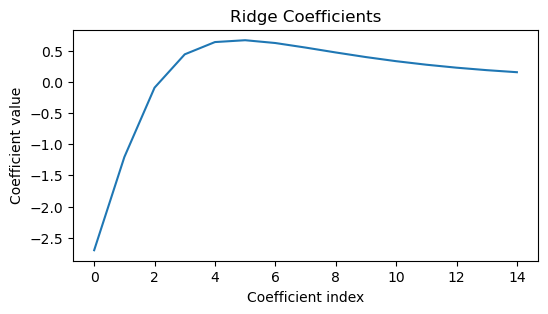

In [109]:

plt.figure(figsize=(6, 3))
plt.plot(pipeline.named_steps['lr'].coef_[:])
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('OLS Coefficients')

plt.figure(figsize=(6, 3))
plt.plot(pipeline2.named_steps['lr'].coef_[:])
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('Ridge Coefficients')


# The bias-variance tradeoff

+ I can either have a jack-of-all-trades model that is good at everything, but which requires a lot of data to train, or I can have a model that is good at a specific task, and which requires less data to train because it has high bias.

+ Underfitting: high bias, low variance. The model has a strong "bias" towards a certain shape, and is inflexible to capture all of the peculiarities of the training data. 

+ Overfitting: low bias, high variance. The model is flexible, but overfits because it attempts to capture all of the peculiarities of the training data, some of which may result from noise or other factors that are not present in the test data.

+ In physics, we often have "inductive bias" towards certain models. For example, we might know that energy is conserved, or that certain symmetries exist. This is a form of bias that can help us learn from less data, by restricting model space.

# Hyperparameter Search

+ The Ridge penalty parameter $\lambda$ as a **hyperparameter**, because it's a high-level parameter that controls the properties of the model, rather than a parameter that is learned from the data.

+ We can set $\lambda$ by assessing performance on a held-out validation dataset, or we can use cross-validation to select $\lambda$ from subsets of the training data.

# L1 vs. L2 Regularization

Recall that L2 regularization (Ridge or Tikhonov) is defined as

$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \frac{\lambda}{2} \cdot ||\theta||_2^2.$$

L1 regularization (Lasso or Sparse) is defined as

$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \lambda \cdot ||\theta||_1.$$

Where $||\theta||_1 = \sum_{j=1}^d |\theta_j|$ is the L1 norm of $\theta$.

These two regularizers look pretty similar: both deter the values of $\theta$ from becoming too large. Mathematically, both are convex, both are non-negative, and both are differentiable almost everywhere. 

However, in practice, they turn out to have very different effects on the learned model. To see this, we will re-run the polynomial regression example with both L1 and L2 regularization, and then see how the learned weights change as $\lambda$ is varied.

(3.1622776601683794e-11,
 3.1622776601683795,
 -4.526466184182928,
 3.0015518512925308)

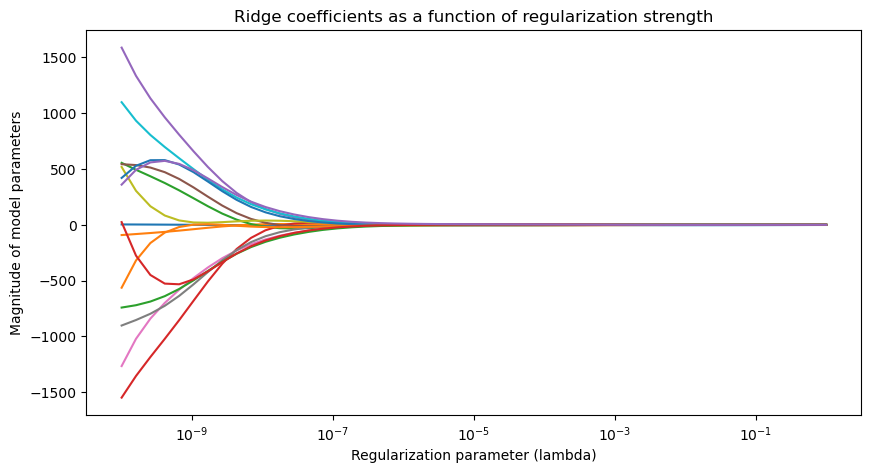

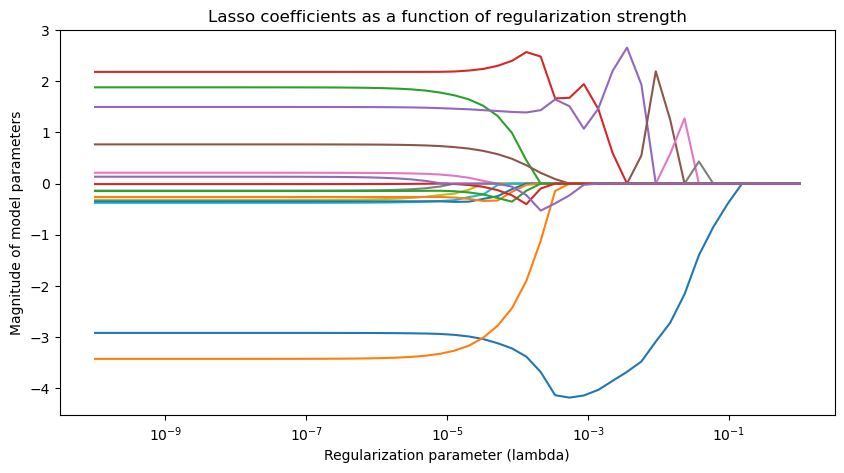

In [7]:
from sklearn.linear_model import Lasso, Ridge

# create ridge coefficients
alphas = np.logspace(-10, 0, 50)
ridge_coefs = []
for a in alphas:
    polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
    linear_regression = Ridge(alpha=a) # sklearn uses alpha instead of lambda
    pipeline2 = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline2.fit(X_train[:, None], y_train)   

    ridge_coefs.append(pipeline2.named_steps['lr'].coef_)

# plot ridge coefficients
plt.figure(figsize=(10, 5))
plt.semilogx(alphas, ridge_coefs)
plt.xlabel('Regularization parameter (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Ridge coefficients as a function of regularization strength')
plt.axis('tight')

lasso_coefs = []
for a in alphas:
    polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
    linear_regression = Lasso(alpha=a) # sklearn uses alpha instead of lambda
    pipeline2 = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline2.fit(X_train[:, None], y_train)   

    lasso_coefs.append(pipeline2.named_steps['lr'].coef_)

# plot lasoo coefficients
plt.figure(figsize=(10, 5))
plt.semilogx(alphas, lasso_coefs)
plt.xlabel('Regularization parameter (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Lasso coefficients as a function of regularization strength')
plt.axis('tight')

## What happened here?

+ We can see that L1 regularization has a tendency to set many of the weights to zero, while L2 regularization tends to smoothly shrink the weights towards zero.

+ In practice, L2 regularization leads to a smoother model. in which all of the features are used, but none of them are used too much. These models often have smoother decision boundaries than L1-regularized models, and they are more robust to noise or sampling bias in the training data.

+ However, L1 regularizion forces the model to avoid using many of the features, which can make the model more interpretable. For example, if two features contain redundant information, L1 regularization will help the model to choose one of them. This can be useful in feature selection or in reducing the complexity of a model.

+ In modern deep learning, L2 regularization is used more often. However, in smaller-scale machine learning, when feature selection matters it is commong to first fit an L1-regularized model, and then drop all features from the training dataset that have zero weights (this is equivalent to dropping the corresponding columns of the feature matrix). Then an L2-regularized model is fit on this reduced dataset. This procedure is called ***sequential feature selection.**

# An emerging topic: double descent

+ We've seen how regularization helps us to control the complexity of a model, which is equivalent to navigating the bias-variance tradeoff.

+ However, what happens if we increase the model complexity well beyond the point where we start to overfit? 

+ This example is based on [Daniela Witten's description of double descent](https://twitter.com/daniela_witten/status/1292293102103748609)

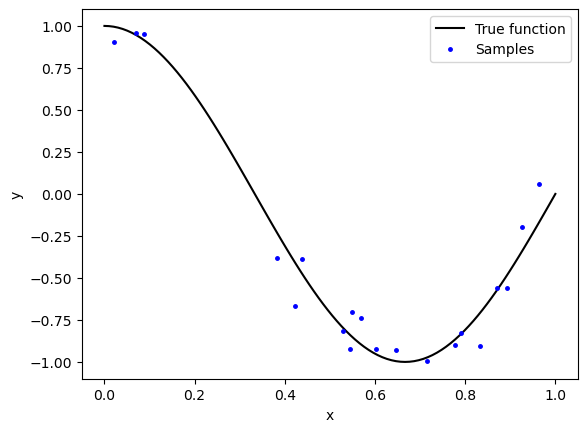

In [8]:
## Make a dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

true_fn = lambda X: np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 20
# X = np.linspace(0, 1, n_samples)
X_train = np.random.rand(n_samples)
y_train = true_fn(X_train) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
y_test = true_fn(X_test)

plt.plot(X_test, y_test, 'k', label="True function")
plt.plot(X_train, y_train, '.b', markersize=5, label="Samples")
plt.xlabel("x")
plt.ylabel("y")

plt.legend(loc="best")

We will now fit a polynomial regression model, and visually inspect how the model behaves as we increase the degree of the polynomial.

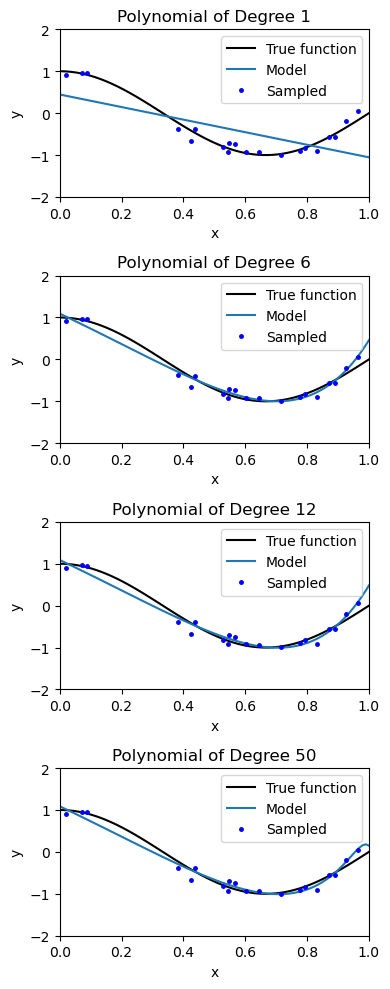

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

degrees = [1, 6, 12, 50]
plt.figure(figsize=(4, 10))
for i in range(len(degrees)):
    

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    ridge_regression = Ridge(alpha=0.01)
    pipeline = Pipeline([("pf", polynomial_features), ("lr", ridge_regression)])
    pipeline.fit(X_train[:, None], y_train)

    ax = plt.subplot(len(degrees), 1, i + 1)
    ax.plot(X_test, true_fn(X_test), color='k', label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.plot(X_train, y_train, '.b', markersize=5, label="Sampled")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()

    ## Plot residuals for each model
    # ax = plt.subplot(len(degrees), 1, i + 1)
    # ax.plot(X_test, true_fn(X_test) - pipeline.predict(X_test[:, np.newaxis]), '.b', markersize=5, label="Samples")
    # ax.set_xlim((0, 1))
    # ax.set_ylim((-1, 1))
    # plt.xlabel("x")
    # plt.ylabel("Test Residuals")
    # plt.tight_layout()


We can see that the model slightly overfits the data, but at some point the overfitting stops getting any worse. Our intuition is that, once the model has enough capacity to fit all $N$ training datapoints, the extra degrees of freedom in the model are underspecified by the data.

Text(0, 0.5, 'Test Error')

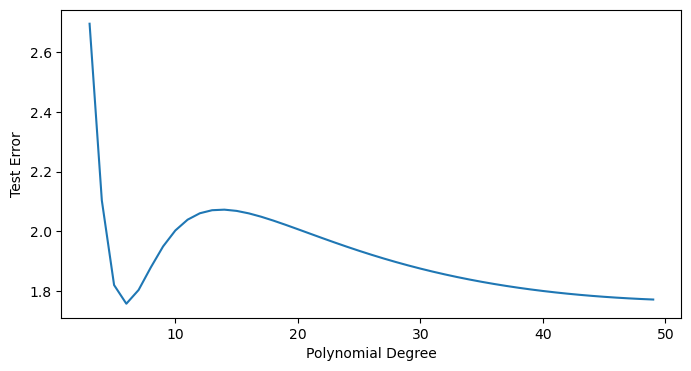

In [11]:
from sklearn.linear_model import Ridge

degrees = np.arange(3, 50)
all_train_scores, all_test_scores = list(), list()
all_coefs0, all_coefs = [], []
for i in range(len(degrees)):

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    # linear_regression = RidgeCV()
    linear_regression = Ridge(alpha=0.1)
    # linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_train[:, None], y_train)
    y_pred_train = pipeline.predict(X_train[:, None])
    y_pred_test = pipeline.predict(X_test[:, None])

    all_train_scores.append(np.sqrt(np.sum((y_pred_train - y_train)**2)))
    all_test_scores.append(np.sqrt(np.sum((y_pred_test - y_test)**2)))
    all_coefs.append(pipeline.named_steps['lr'].coef_)

plt.figure(figsize=(8, 4))
plt.plot(degrees, all_test_scores)
# plt.plot(degrees, all_train_scores)
plt.xlabel('Polynomial Degree')
plt.ylabel('Test Error')

## What's going on?

+ [Double descent](https://www.pnas.org/doi/abs/10.1073/pnas.1903070116) was first described in 2018!

+ It seemingly violates classical statistics, where too many parameters lead to overfitting and thus rising test error.

+ When $p > n$ (more features than data), the model is overparameterized and the training error can be made arbitrarily small.

+ Unexpectedly, the test error starts decreasing again as $p = n$ (the interpolation threshold, where the number of features is equal to the number of data points)

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/double descent pnas 2019.png" alt="double descent PNAS paper" style="width: 650px;"/>

Header from [Belkin et al 2019](https://www.pnas.org/doi/10.1073/pnas.2003206117)

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/pnas.1903070116fig01.jpeg" alt="double descent schematic" style="width: 750px;"/>

Fig. 1 from [Belkin et al 2019](https://www.pnas.org/doi/10.1073/pnas.2003206117)

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/pnas.1903070116fig02.jpeg" alt="double descent curves" style="width: 750px;"/>

Fig. 2 from [Belkin et al 2019](https://www.pnas.org/doi/10.1073/pnas.2003206117)

## How does this happen? The overparameterized regime

+ The least-squares problem is underdetermined, and so there are multiple possible solutions once we pass the interpolation threshold.

+ Given many equivalent solutions, `scikit-learn`'s `Ridge` chooses the solution that minimizes the L2 norm of the coefficients

+ When $p$ gets arbitrarily large, then there are more possible solutions to choose from. The one that minimize the L2 norm of the coefficients ends up being closer to the correct solution, and the test error decreases again.

+ Double descent is a loose argument for why neural networks work so well, despite often having many more parameters than data points. Overparametrization gives them more flexibility to find a good solution.


## Implicit Regularization


Text(0, 0.5, 'L2 norm of coefficients')

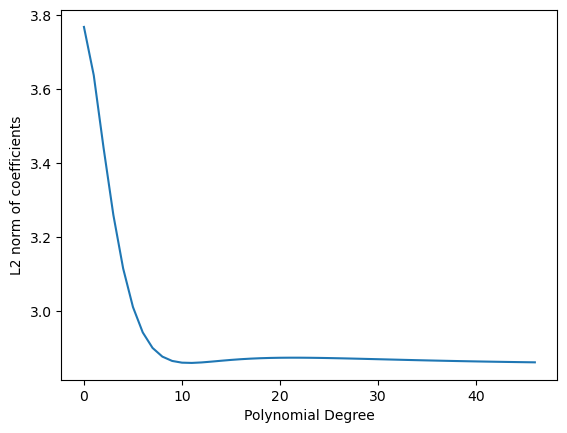

In [248]:
plt.plot([np.std(item) * np.sqrt(len(item)) for item in all_coefs])
plt.xlabel('Polynomial Degree')
plt.ylabel('L2 norm of coefficients')

# plt.ylim([2.8, 2.9])